# Assignment 5 - Reinforcement Learning

## SOLUTIONS

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [85]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [86]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(12, 10, False)
((21, 10, False), 0, False)


**ANSWER**

My average reward was -0.18 after playing 50 hands (answers will vary based on skill level).

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Repeat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

**(a)** The implementation of Monte Carlo policy evaluation:

In [87]:
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

def policy_evaluation(episodes):
    # Initialize variables
    avg_reward = []    # Accumulator to store the total average reward over all episodes
    N          = 0     # Number of episodes played
    N_player   = 32    # The max value is 21, but then if the player busts they could reach 32
    N_dealer   = 10    # Maximum number of values the dealer's hand can take on
    N_ace      = 2     # There are two states for the ace: (1) No usable ace, (2) Usable ace
    
    # Initialize the value function (in this case, the value function is the 
    #   average return over episodes, so no need for an explicit returns array)
    v = np.zeros((N_player, N_dealer, N_ace))
    
    # Initialize a variable counting the number of visits to each state
    n_visits = np.zeros((N_player, N_dealer, N_ace))
    
    # Initialize the policy that stays only if the player has 20 or 21
    stay_values           = np.array([20, 21])
    pi                    = np.ones((N_player, N_dealer, N_ace))
    pi[stay_values-1,:,:] = 0
    
    # Load the game
    B = Blackjack()
    
    # Convert the current state into a set of indices for the value function
    def state_to_index(s):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0]-1, s[1]-1, ace]
        return index
    
    # Choose an action based on the policy, pi
    def choose_action(pi,s):
        index = state_to_index(s)
        return pi[tuple(index)]
    
    # Update the returns for a state
    def update_returns(returns,reward,state_index,n_visits):
        R_previous     = returns[tuple(state_index)]
        N              = n_visits[tuple(state_index)]
        R_current      = reward
        updated_return = (1/N)*R_current + ((N-1)/N)*R_previous
        return updated_return
    
    # ----------------------------------------------------------------------
    # Run the policy evaluation    
    # ----------------------------------------------------------------------
    for episode in range(episodes):
           
        # Deal a hand of blackjack
        s       = B.deal()  # Deal the hand
        states  = []        # Initialize an array to store the states for this hand
        states.append(state_to_index(s)) # Append the initially dealt state
        endgame = False     # Flag to indicate if the end of game was reached
        
        # Play the hand through
        while not endgame:
            a             = choose_action(pi,s)
            s, r, endgame = B.step(a)
            states.append(state_to_index(s))
        
        # Keep track of the average reward
        N += 1
        if N == 1:
            avg_reward.append(r)
        else:
            next_average = (1/N)*r + ((N-1)/N)*avg_reward[-1]
            avg_reward.append(next_average)
        
        # Assign the rewards of this episode to the corresponding states
        # In this case, all of the rewards were assigned to each state, since in 
        #  blackjack all the rewards occur at the end, and each state is unique
        #  along the way
        for s in states:
            # Update the number of visits to each state
            n_visits[tuple(s)] += 1
            
            # Calculate the average return
            average_return = update_returns(v,r,s,n_visits)
            v[tuple(s)] = average_return
    return (v, avg_reward)

In [88]:
# ---------------------------------------------------------------------------
# Define the plotting functions for value and average rewards
# ---------------------------------------------------------------------------        
%config InlineBackend.figure_format = 'retina'

# Plot the resulting Value function (expected rewards from each state)
def plot_value(v):
    plt.figure(figsize=(10,7))
    drange = [1,10]
    prange = [4,21]
    axes = []
    axes.append(plt.subplot(1,2,1))
    plt.title('No Usable Ace')
    plt.imshow(v[prange[0]-1:prange[1],:,0], 
               vmin=-1,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'RdBu')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    
    axes.append(plt.subplot(1,2,2))
    plt.title('Usable Ace')
    im = plt.imshow(v[prange[0]-1:prange[1],:,1], 
               vmin=-1,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'RdBu')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    cbar = plt.colorbar(im, ax=axes)
    cbar.set_label('Value (Expected Returns)')

def plot_average_reward(avg_reward):
    # Plot the average reward over time
    plt.figure(figsize=(7,7))
    plt.plot(avg_reward,'k')
    plt.axis([0,len(avg_reward),-1,1])
    plt.grid('on')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')

In [89]:
# Run policy evaluation for 10,000 and 500,000 episodes, respectively:
v10, avg_reward_10   = policy_evaluation(10000)
v500, avg_reward_500 = policy_evaluation(500000)

**(a)** 1-2. Value functions after 10,000 iterations of policy evaluation:

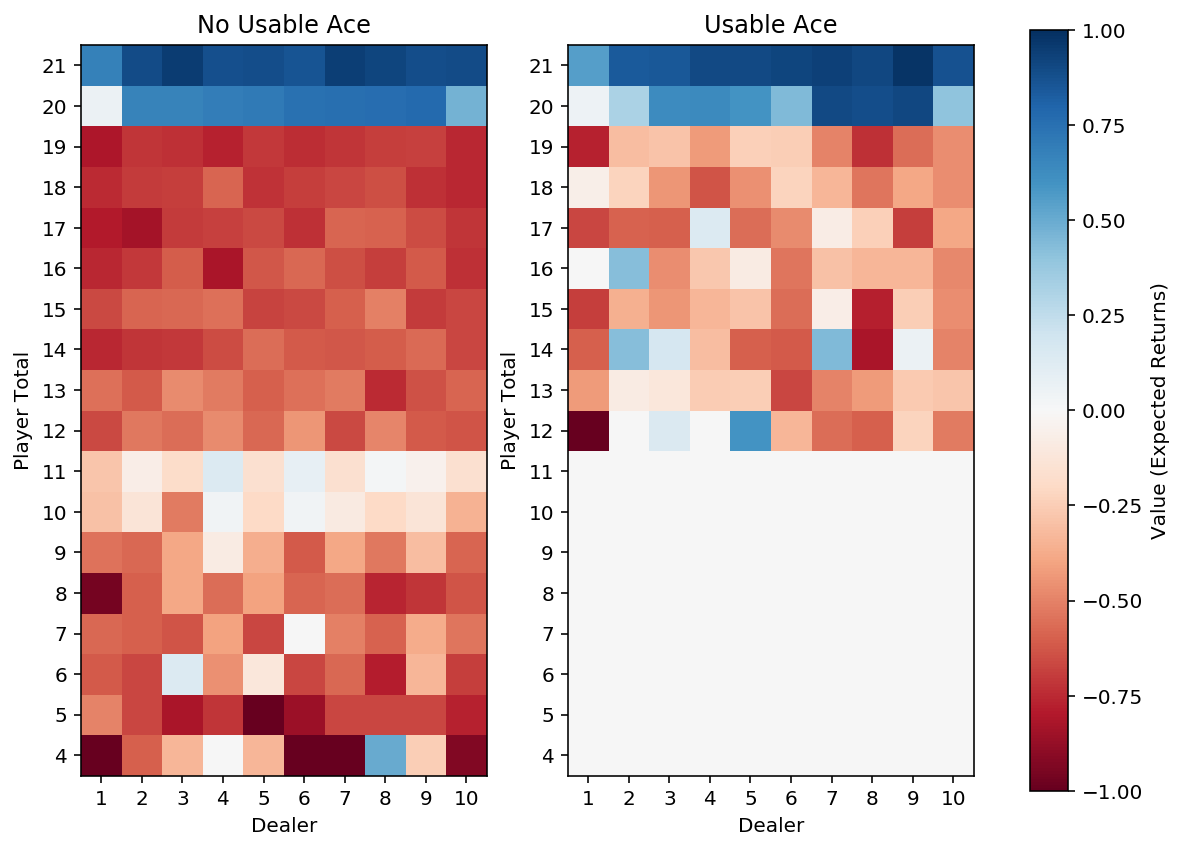

In [90]:
# Plot the value function after 10,000 iterations of policy evaluation
plot_value(v10)
plt.show()

**(a)** 3-4. Value functions after 500,000 iterations of policy evaluation:

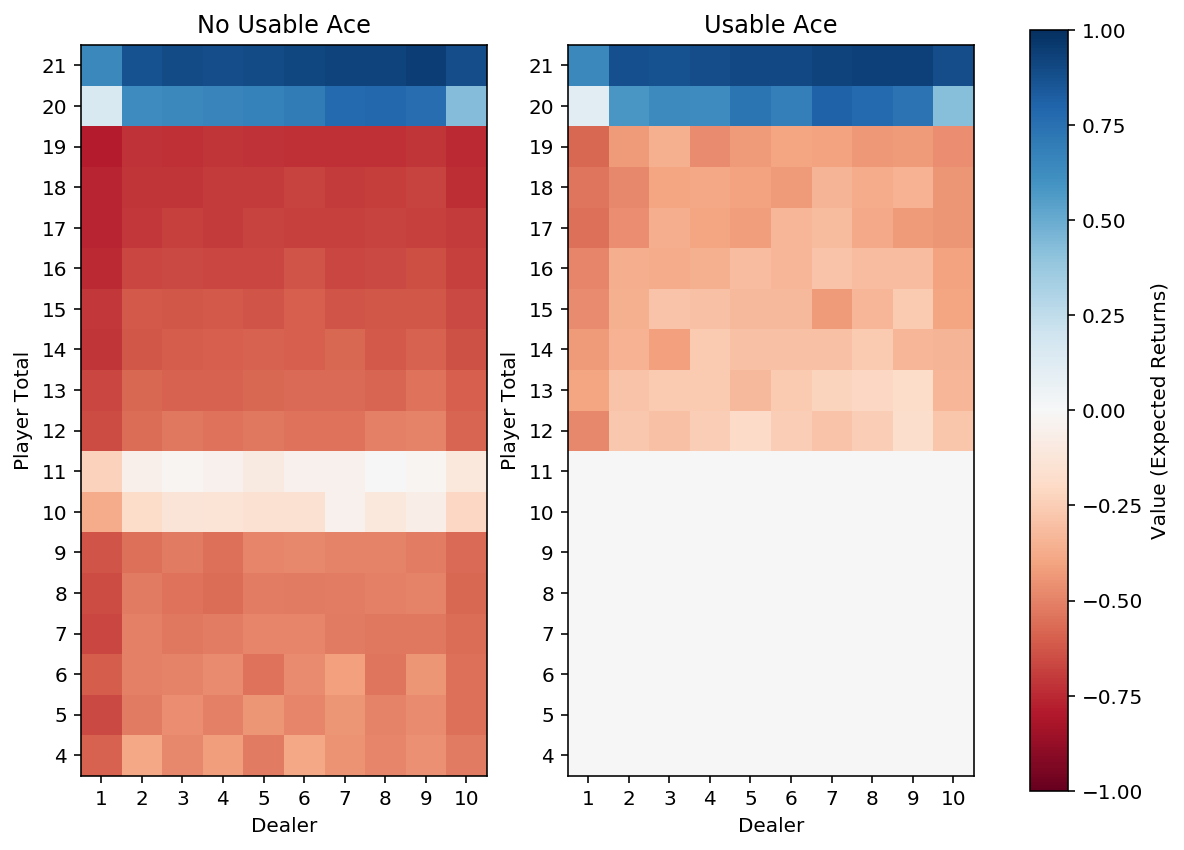

In [91]:
# Plot the value function after 500,000 iterations of policy evaluation
plot_value(v500)
plt.show()

**(b)** The average reward after 10,000 and 500,000 episodes is shown below along with the average reward at each episode:

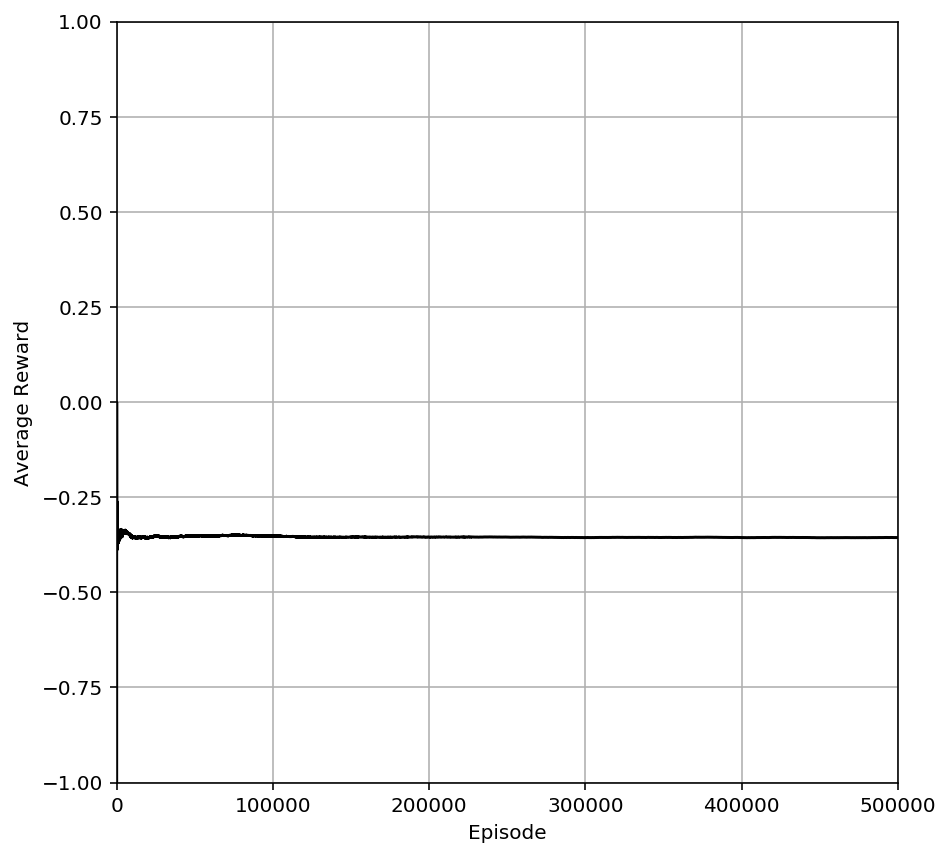

Average reward after  10,000 episodes = -0.3559
Average reward after 500,000 episodes = -0.356


In [92]:
plot_average_reward(avg_reward_500)
plt.show()
print('Average reward after  10,000 episodes = {:.4}'.format(avg_reward_500[10000]))
print('Average reward after 500,000 episodes = {:.4}'.format(avg_reward_500[-1]))

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

**(a)** First, create the Monte Carlo Control function implementing policy iteration

In [93]:
def mc_control(episodes):
    N_player  = 32
    N_dealer  = 10
    N_ace     = 2
    N_actions = 2
    
    avg_reward = []
    N          = 0
    N0         = 1 # Coefficient for controlling the level of exploraiton
    # Initialize the value function (in this case, the value function is the 
    #   average return over episodes, so no need for an explicit returns array)
    v = np.zeros((N_player, N_dealer, N_ace))
    q = np.zeros((N_player, N_dealer, N_ace, N_actions))
    
    # Initialize a variable counting the number of visits to each state
    nv_visits  = np.zeros((N_player, N_dealer, N_ace))            # For the value function
    nav_visits = np.zeros((N_player, N_dealer, N_ace, N_actions)) # For the action value function
    
    # Initialize the policy to all always stay
    pi         = np.zeros((N_player, N_dealer, N_ace))
    
    # Initialize the game
    B  = Blackjack()

    # Conver the current state into a set of indices for the value function
    def state_to_index_v(s):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0]-1, s[1]-1, ace]
        return index
    
    # Conver the current state into a set of indices for the action value function
    def state_to_index_av(s,a):
        ace = 0
        if s[2]:
            ace = 1
        index = [s[0]-1, s[1]-1, ace, int(a)]
        return index
    
    # Choose an action based on the policy, pi
    def choose_action(pi,s):
        index = state_to_index_v(s)
        a = pi[tuple(index)]
        
        # Add epsilon-greedy exploration strategy
        Ns = nv_visits[tuple(index)]
        epsilon = N0 / (N0 + Ns)
        # With a small probability choose the other action
        if np.random.rand() < epsilon:
            a = 1 - a
        return int(a)
    
    # Update the returns for a state for the value function
    def update_returns_v(returns,reward,state_index,n_visits):
        R_previous     = returns[tuple(state_index)]
        N              = nv_visits[tuple(state_index)]
        R_current      = reward
        updated_return = (1/N)*R_current + ((N-1)/N)*R_previous
        return updated_return
    
    # Update the returns for a state for the acion value function
    def update_returns_av(returns,reward,state_index,n_visits):
        R_previous     = returns[tuple(state_index)]
        N              = nav_visits[tuple(state_index)]
        R_current      = reward
        updated_return = (1/N)*R_current + ((N-1)/N)*R_previous
        return updated_return
    
    # ----------------------------------------------------------------------
    # Run episodes of MC Control    
    # ----------------------------------------------------------------------
    for episode in range(episodes):
        # Play a hand a blackjack
        s = B.deal()
        states_v = []
        states_av = []
        states_v.append(state_to_index_v(s))
        endgame = False
        
        while not endgame:            
            a = choose_action(pi,s)
            s, r, endgame = B.step(a)
            states_v.append(state_to_index_v(s))
            states_av.append(state_to_index_av(s,a))        
        
        # Update average reward count
        N += 1
        if N == 1:
            avg_reward.append(r)
        else:
            next_average = (1/N)*r + ((N-1)/N)*avg_reward[-1]
            avg_reward.append(next_average)
        
        # Update the state value function
        # Update the number of visits to each state and calculate the average return
        for s in states_v:
            # 
            nv_visits[tuple(s)] += 1
            average_return_v    = update_returns_v(v,r,s,nv_visits)
            v[tuple(s)]         = average_return_v
        
        # Update the action value function
        # Update the number of visits to each state and calculate the average return
        for s in states_av:
            nav_visits[tuple(s)] += 1
            average_return_av    = update_returns_av(q,r,s,nav_visits)        
            q[tuple(s)]          = average_return_av
            
            # Update the policy
            cstate     = tuple(s[0:3])
            pi[cstate] = np.argmax(q[cstate])
    return (v,pi, avg_reward)

Below are functions for plotting the policy

In [94]:
def plot_policy(pi):
    # Plot the policy
    drange = [1,10]
    prange = [4,21]
    plt.figure(figsize=(10,7))
    axes = []
    axes.append(plt.subplot(1,2,1))
    plt.title('No Usable Ace')
    plt.imshow(pi[prange[0]-1:prange[1],:,0], 
               vmin=0,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'binary_r')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    
    axes.append(plt.subplot(1,2,2))
    plt.title('Usable Ace')
    im = plt.imshow(pi[prange[0]-1:prange[1],:,1], 
               vmin=0,vmax=1,
               origin='lower', 
               extent=(drange[0]-0.5,
                       drange[1]+0.5,
                       prange[0]-0.5,
                       prange[1]+0.5),
               cmap = 'binary_r')
    plt.xticks(np.arange(drange[0],drange[1]+1,1))
    plt.yticks(np.arange(prange[0],prange[1]+1,1))
    plt.ylabel('Player Total')
    plt.xlabel('Dealer')
    cbar = plt.colorbar(im, ax=axes)
    cbar.set_label('Action (Stay = 0, Hit = 1)')

Run the Monte Carlo control algorithm for many episodes:

In [95]:
# MC Control
episodes = 50000000
v, pi, avg_reward = mc_control(episodes)

**(a)** 1-2. Plot the value function for the best policy:

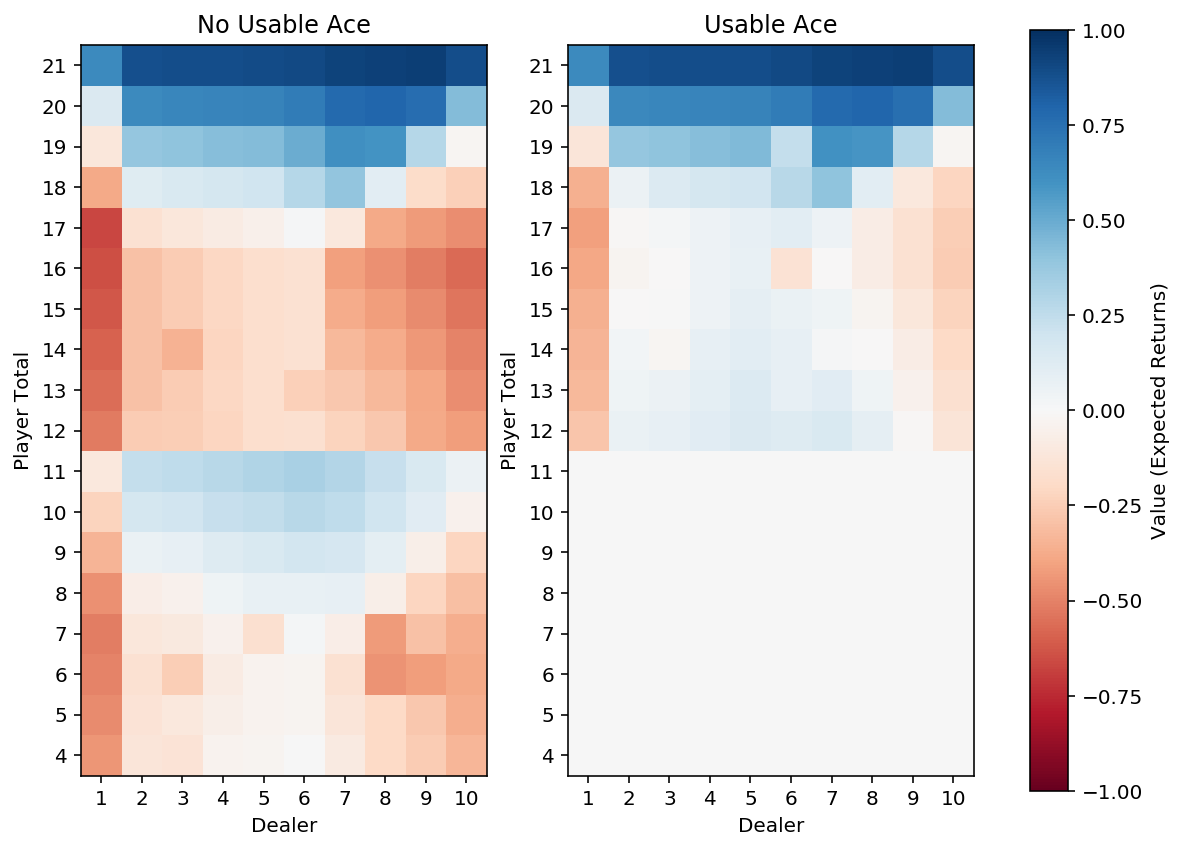

In [96]:
plot_value(v)
plt.show()

**(a)** 3-4. Plot the best policy that was determined by Monte Carlo Control:

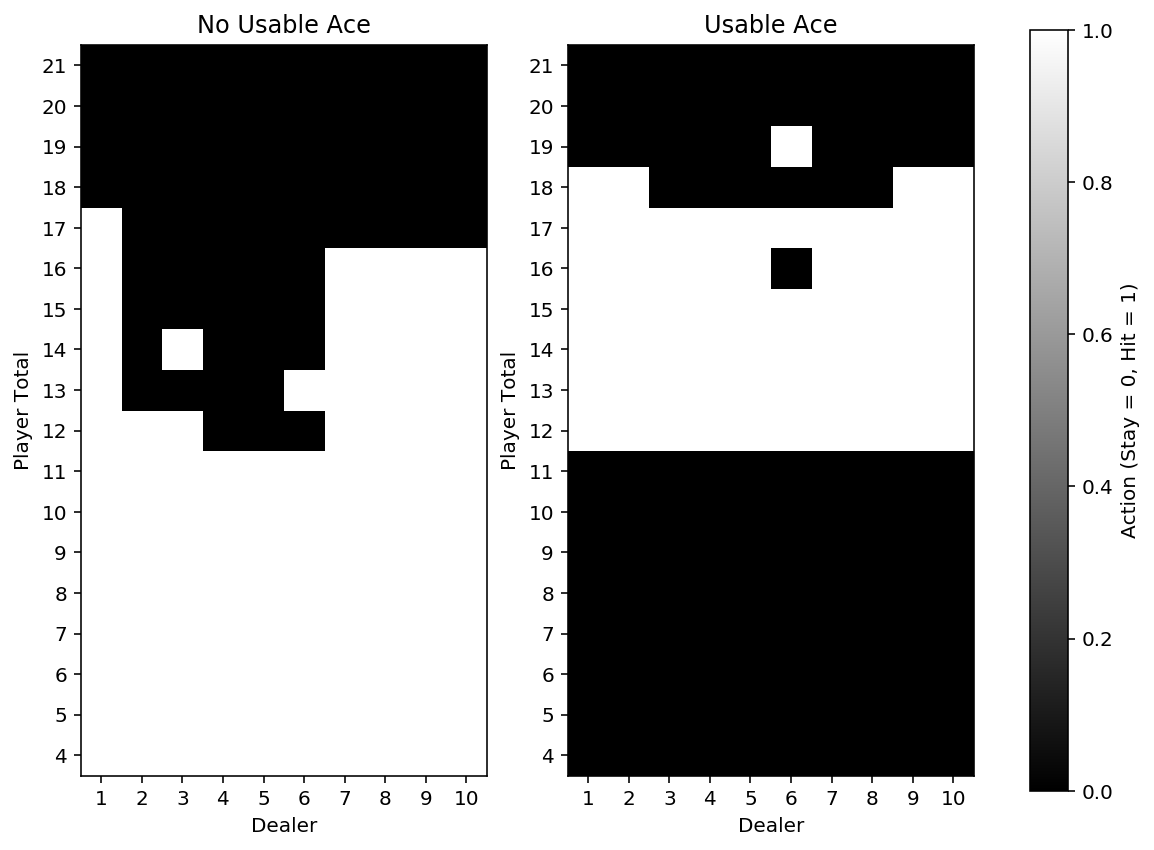

In [97]:
plot_policy(pi)
plt.show()

**(b)** Plot the average reward function as it converges onto the optimal policy:

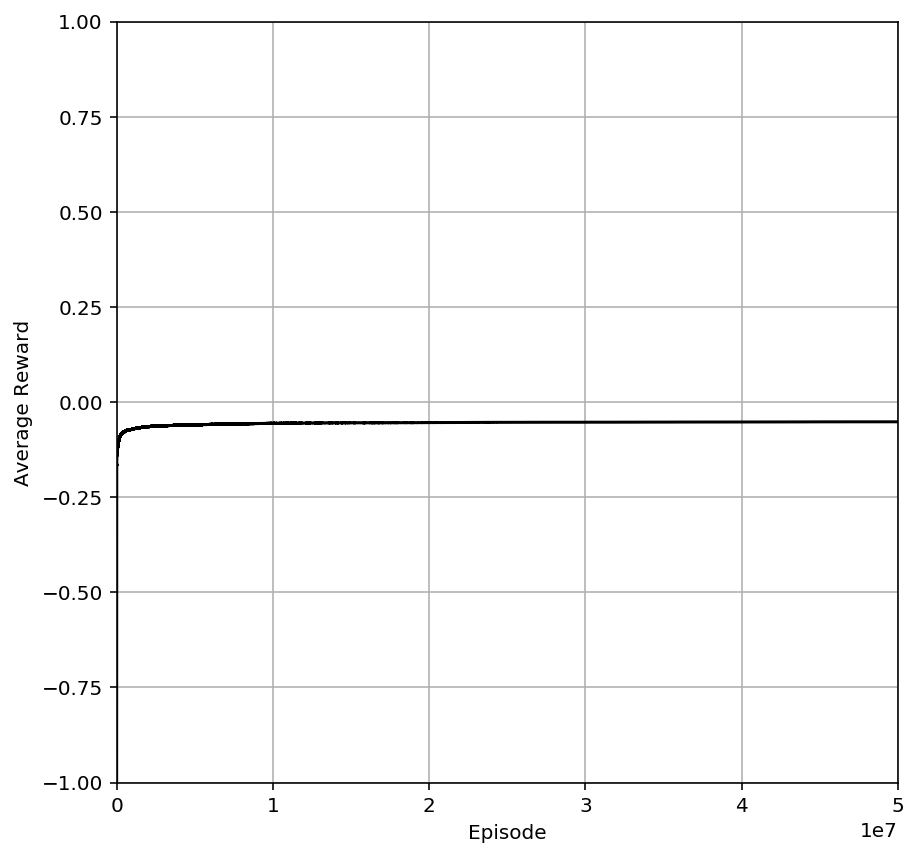

Average reward after all episodes = -0.05182


In [98]:
plot_average_reward(avg_reward)
plt.show()
print('Average reward after all episodes = {:.4}'.format(avg_reward[-1]))

Of course, even though the above was run for a very long time, it did not fully converge. This needs to be run for many more iterations to fully converge, at which time your policy function will look like this:
![Policy Function](img/a5_value.png)

And your optimal policy will looks like this:
![Policy Function](img/a5_policy.png)

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

**(a)** In the human control example, I was able to achieve an average reward of -0.18. The naive policy of only staying with 20 or 21 yielded a much lower average reward of -0.36, and the optimal control policy yielded a considerably improved -0.05 average reward. My own strategy, which was roughly to hit if my player sum was below 17. However, the optimal decision strategy was much more complex than this which very much depended on the dealer's visible card. The policy in question 2 was far too naive to perform well, as was my own policy, neither of which factored in the dealer's card.

**(b)** Since we applied Monte Carlo Control, as the number of episodes approaches infinity, this is guaranteed to converge onto the optimal policy. However, we were not able to run an infinite number of trials, therefore, this is an approximation. However, given the number of trials run and how little the policy was changing towards the end of those trials, we can have confidence that our solution is close to optimal (in fact the final image of the policy shown above is the optimal policy). In that case, knowning the full MDP would not be able to create a better policy, because we have converged upon the best policy already.